In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\code\covid-project\training",  # Added 'r' prefix to treat as raw string
    # OR use double backslashes: "C:\\code\\covid-project\\training"
    # OR use forward slashes: "C:/code/covid-project/training"
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5228 files belonging to 3 classes.


In [20]:
class_names = dataset.class_names
class_names

['COVID', 'NORMAL', 'PNEUMONIA']

In [21]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 2 2 1 1 1 2 0 0 0 0 1 2 1 1 1 0 1 0 0 1 2 1 1 1 1 0 1]


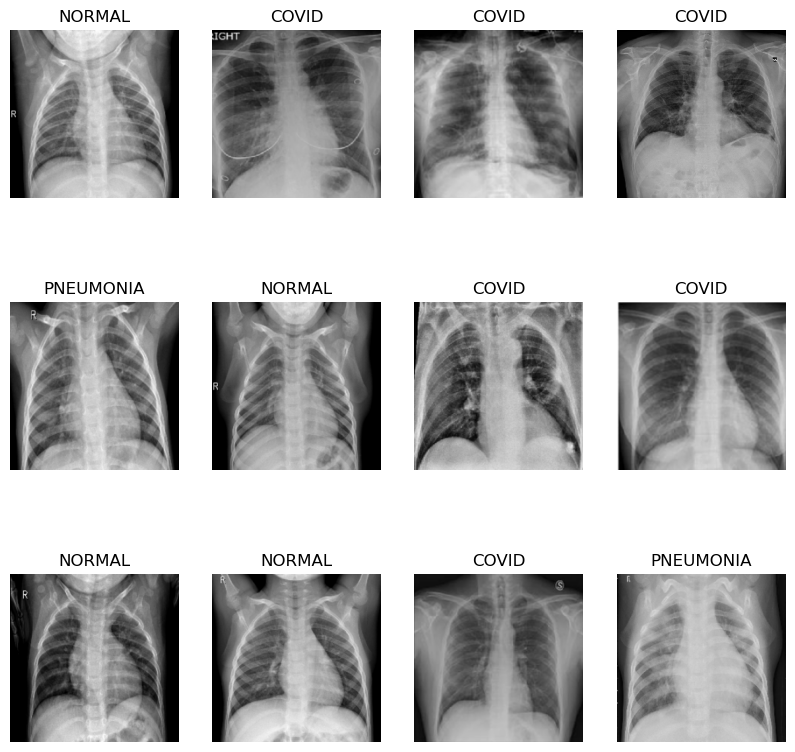

In [22]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [23]:
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
# Extract all labels from the dataset
labels = []
for _, label_batch in dataset.unbatch():  # Iterate through all batches
    labels.append(label_batch.numpy())

# Count occurrences of each class
unique_classes, counts = np.unique(labels, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Class '{class_names[cls]}' has {count} images")

Class 'COVID' has 1626 images
Class 'NORMAL' has 1802 images
Class 'PNEUMONIA' has 1800 images


In [25]:
# Calculate the total number of images in the dataset
total_samples = 0
for _ in dataset.unbatch():  # Unbatch to count individual samples
    total_samples += 1

print(f"Total number of images in the dataset: {total_samples}")

Total number of images in the dataset: 5228


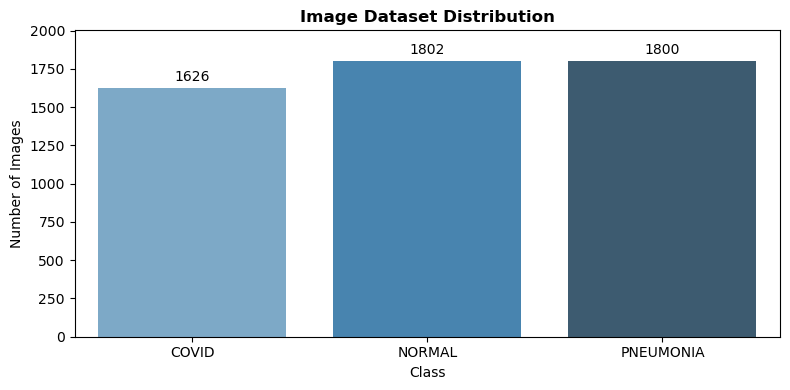

In [26]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=class_names, y=counts, palette="Blues_d")
# ===== OPTION 1: Modern (Matplotlib ≥ 3.4.0) =====
# (Best for simplicity)
ax.bar_label(ax.containers[0], padding=3, fontsize=10)
plt.title("Image Dataset Distribution", fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.ylim(0, max(counts) + 200)  # Adjust y-limit for spacing
plt.tight_layout()
plt.show()

In [27]:
80% - training
20% - test
    10% - validation
    10% - testing

IndentationError: unexpected indent (2532504208.py, line 3)

In [60]:
train_size = 0.8
len(dataset)*train_size

131.20000000000002

In [62]:
train_ds = dataset.take(131)
len(train_ds)

131

In [64]:
test_ds = dataset.skip(131)
len(test_ds)

33

In [66]:
val_size = 0.1
len(dataset)*val_size

16.400000000000002

In [68]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [70]:
test_ds = test_ds.skip(6)
len(test_ds)

27

In [34]:
# Load dataset
data_dir = r"C:\code\covid-project\training"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

raw_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=False,  # Maintain order for correct splitting
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Prepare data
file_paths = np.array(raw_ds.file_paths)
labels = np.concatenate([y for x, y in raw_ds], axis=0)
class_names = raw_ds.class_names

# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, 
    test_size=0.2,  # 20% temporary holdout
    stratify=labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # Split 20% into 10% val and 10% test
    stratify=y_temp,
    random_state=42
)

# Verify splits
print(f"\nDataset splits:")
print(f"Train: {len(X_train)} images ({len(X_train)/len(file_paths):.0%})")
print(f"Val: {len(X_val)} images ({len(X_val)/len(file_paths):.0%})")
print(f"Test: {len(X_test)} images ({len(X_test)/len(file_paths):.0%})")

Found 5228 files belonging to 3 classes.

Dataset splits:
Train: 4182 images (80%)
Val: 523 images (10%)
Test: 523 images (10%)


In [44]:
import tensorflow as tf
import numpy as np

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# 1. Correct Data Augmentation Function
def augment_image(image, label):
    """Applies random transformations to training images"""
    # Random left/right flip
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Random zoom (crop + resize)
    if tf.random.uniform(()) > 0.5:
        zoom_factor = tf.random.uniform((), 0.9, 1.0)
        h, w = IMG_SIZE[0], IMG_SIZE[1]
        new_h = tf.cast(h * zoom_factor, tf.int32)
        new_w = tf.cast(w * zoom_factor, tf.int32)
        image = tf.image.random_crop(image, size=[new_h, new_w, 3])
        image = tf.image.resize(image, IMG_SIZE)
    
    return tf.clip_by_value(image, 0, 255), label  # Keep pixels in valid range

# 2. Dataset Builder Function
def build_dataset(image_paths, labels, shuffle=True, augment=False):
    """Builds optimized TensorFlow dataset pipeline"""
    
    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        return image, label
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply augmentation if requested
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Performance optimizations
    dataset = dataset.cache()  # Cache after loading/augmentation
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

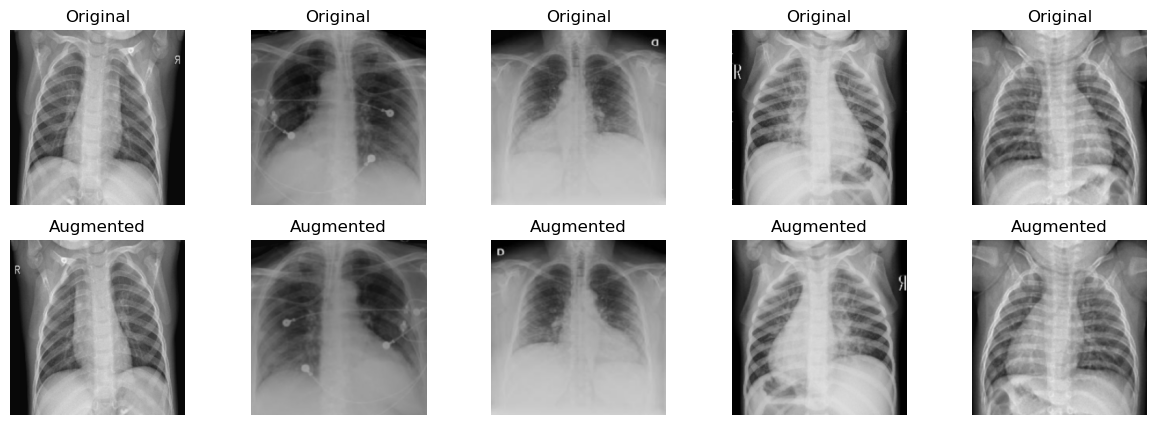

In [46]:
# Take 5 sample images from your training set
sample_images = []
for img, label in train_ds.take(1):  # Takes first batch (32 images)
    for i in range(5):  # Pick first 5 images
        sample_images.append(img[i])

# Show original vs augmented versions
plt.figure(figsize=(15, 5))
for i in range(5):
    # Original image
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")
    
    # Augmented image
    augmented, _ = augment_image(sample_images[i], 0)  # 0 is a dummy label
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(augmented.numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.show()

In [75]:
# 3. Create datasets
train_ds = build_dataset(X_train, y_train, shuffle=True, augment=True)
val_ds = build_dataset(X_val, y_val, shuffle=False)
test_ds = build_dataset(X_test, y_test, shuffle=False)

# Verify
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Training batches: 131
Validation batches: 17
Test batches: 17


In [ ]:
/*
✅ Confirmed Correct Splitting
Dataset	Images	Percentage	Batches (32 img/batch)
Train	4,182	80%	          131
Val	    523	    10%	          17
Test	523	    10%	          17*/

In [83]:
# from tensorflow.keras import layers, models, regularizers

# def create_cnn_model():
#     model = models.Sequential([
#         # Input layer (images already resized to 256x256 via dataset)
#         layers.Input(shape=(256, 256, 3)),
        
#         # Light augmentation (applied only during training)
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.05),
#         layers.RandomZoom(0.05),
        
#         # Conv Block 1
#         layers.Conv2D(32, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),
        
#         # Conv Block 2
#         layers.Conv2D(64, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),
        
#         # Conv Block 3
#         layers.Conv2D(128, (3,3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2,2)),
        
#         # Feature aggregation
#         layers.GlobalAveragePooling2D(),
        
#         # Classifier
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(3, activation='softmax')  # 3 classes: COVID/Pneumonia/Normal
#     ])
#     return model

In [94]:
# Revised model architecture
model = tf.keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Rescaling(1./255),
    
    # Reduced augmentation
    layers.RandomFlip("horizontal"),
    # Removed rotation/zoom for medical images
    
    # Smaller Conv blocks
    layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    # Added dropout
    layers.Dropout(0.3),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)     

In [89]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss='sparse_categorical_crossentropy',
#     # metrics=['accuracy']
# )

In [ ]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced from 0.001
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',  # Now watching loss
#         patience=3,
#         restore_best_weights=True
#     ),
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=2
#     )
# ]

In [91]:
# from tensorflow.keras import callbacks

# # Callbacks
# early_stop = callbacks.EarlyStopping(
#     monitor='val_accuracy', 
#     patience=5,
#     restore_best_weights=True
# )

In [3]:
print('GPU',len(tf.config.experimental.list_physical_devices('GPU')))

GPU 0


In [5]:
tf.test.is_built_with_cude()

AttributeError: module 'tensorflow._api.v2.test' has no attribute 'is_built_with_cude'

In [7]:
print(tf.version.VERSION)

2.12.0


In [9]:
import sys
sys.version

'3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]'